# create 3D maps of prisms with objective / neutral perspective
(location / distance to origin does not matter for size of objects)


## Approach with polygons split to convex shapes
### methods to rely on:
- split polygons to convex shapes
- store convex polys and height in array of objects
- save to object which vertices belong to original objects outline with their indexes to later retain edges of the prisms 
- if opacity of wall color will be alpha=1 then filter out vertices that are not visible anyways:
    - they are not visible if: they the highest point is above line connecting most left and right outwards points
- and to each object add the distance of its closest point to perspective origin
- sort array of objects descending according to that distance measure
- start plotting along the sorted array:
    - plot wall that did belong to original outline
        - color potentially based on orientation 
        - if outline: give border to all walls 
    - plot roof
        - (potentially include a check whether roof is visible at all in the end)
        - fill with color
        - if outline: plot edges that belonged to orignal outline
    - (potentially add shadow along roof and wall in a later stage)
    

### libraries

In [2]:
import shapely
from shapely.geometry import Polygon, LineString, MultiLineString, Point, MultiPolygon, GeometryCollection
from shapely.affinity import translate, scale
from shapely.ops import unary_union
from geopandas import GeoDataFrame, GeoSeries, read_file
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
def angleToNorth (point1:tuple = (0,0), point2:tuple = (0,0)):
    """
    point1 and point2 each must be a tuple of point coords eg. (0,1)
    return angle to north ((0,0) to (0,1))
    """
    xDiff = point2[0] - point1[0]
    yDiff = point2[1] - point1[1]
    
    if(xDiff == 0):
        angle = 0 if(yDiff > 0) else 180
    else:
        angle = -math.atan(yDiff / xDiff) * 180 / math.pi + (270 if(xDiff<0) else 90)
    
    return angle

In [4]:
def addSelfIntersectingCoords(coords) -> list:
    """
    inputs:
    coords = list of coordinates
    """
    edges = [LineString(coords[k:k+2]) for k in range(len(coords) - 1)]
    # 2do check that sorted sorts in correct order
    coordsWithIntersectionPoints = \
        [item for sublist in [[coords[i]]+\
        [item for sublist in \
        [sorted(list(edges[i].intersection(edges[j]).coords),\
        key=lambda intersec: abs(coords[i][0]-intersec[0] + coords[i][1]-intersec[1]))\
        for j in range(len(edges))if not i == j and edges[i].crosses(edges[j])] \
        for item in sublist] \
        for i in range(len(coords)-1)] \
        for item in sublist]
    # print("coordsWithIntersectionPoints",coordsWithIntersectionPoints)
    return coordsWithIntersectionPoints

### function imports:

In [5]:
def definedClockwiseNP (coords:np.ndarray):
    """
    return whether coords that define 2D-shape are defined (mostly) clockwise
    """
    c =  int(all(coords[0] == coords[-1]))

    return sum([(coords[(i+1)%len(coords)][0]-coords[i][0])*(coords[(i+1)%len(coords)][1]+coords[i][1]) for i in range(len(coords) - c)])>0

In [6]:
def definedClockwise (coords):
    """
    return whether coords are defined clockwise
    """
    c =  int(coords[0] == coords[-1])
    
    return sum([(coords[(i+1)%len(coords)][0]-coords[i][0])*(coords[(i+1)%len(coords)][1]+coords[i][1]) for i in range(len(coords))])>0

In [7]:
def noDoubleCoords (coords):
    """
    Function that clean coordinates such a coordinate that directly follows itself is removed
    """
    return [coords[i] for i in range(len(coords)) if not coords[i] == coords[(i+1)%len(coords)]]

In [8]:
def inclusiveSplit (l:list, i:int, j:int, both:bool=True):
    """
    if both not true it will only return the part in between i and j
    comments below show logic. code is more compact
    """
    
    if both:
        return \
            [\
            (l[min(i,j) : max(i,j)+1] + ([] if (max(i,j)<len(l)) else [l[0]])) if i<=j else (l[max(i,j):] +l[:min(i,j)+1]), 
            (l[min(i,j) : max(i,j)+1] + ([] if (max(i,j)<len(l)) else [l[0]])) if i>j else (l[max(i,j):] +l[:min(i,j)+1])\
            ]
    
    if i<=j:
        return (l[min(i,j) : max(i,j)+1] + ([] if (max(i,j)<len(l)) else [l[0]])) if i<=j else (l[max(i,j):] +l[:min(i,j)+1])
        
    return (l[min(i,j) : max(i,j)+1] + ([] if (max(i,j)<len(l)) else [l[0]])) if i>j else (l[max(i,j):] +l[:min(i,j)+1])
    
# x, y = min(i,j), max(i,j)
# partA = l[x : y+1] + ([] if (y<len(l)) else [l[0]])
# partB = l[y:] +l[:x+1]
# if i<=j:
#     part1 = partA
#     part2 = partB
# else:
#     part1 = partB
#     part2 = partA
# if both:
#     return [part1, part2]
# else:
#     return part1

In [9]:
def sideOfVector (point:tuple, vectorEnd:tuple, vectorBase:tuple=(0,0)):
    """
    check whether point is on left or ride side of vector
    does not distinguish between <0 and ==0.
    """
    return \
        (\
        (point[0]-vectorBase[0])*(vectorEnd[1]-vectorBase[1]) - \
        (point[1]-vectorBase[1])*(vectorEnd[0]-vectorBase[0])\
        )>0

In [10]:
def firstConvexCoord (coords):
    i, l =0, len(coords)
    if l < 4:
        return None
    
    if coords[0] == coords[-1]:
        coords = coords[:-1]
    while i < l:
        if (coords[(i+1)%l][0] - coords[(i-1)%l][0])*(coords[i][1] - coords[(i-1)%l][1]) - (coords[(i+1)%l][1] - coords[(i-1)%l][1])*(coords[i][0] - coords[(i-1)%l][0]) >= 0:
            return i
        i+=1
    return None

In [11]:
def firstTwoConvexCoords (coords, two:bool=True):
    i, l =0, len(coords)
    if l < 4:
        return []
    res = []
    if coords[0] == coords[-1]:
        coords = coords[:-1]
    while len(res) < 2 and i < l:
        if (coords[(i+1)%l][0] - coords[(i-1)%l][0])*(coords[i][1] - coords[(i-1)%l][1]) - (coords[(i+1)%l][1] - coords[(i-1)%l][1])*(coords[i][0] - coords[(i-1)%l][0]) >= 0:
            res.append(i)
        i+=1
    return res

In [12]:
def allConvexCoords (coords):
    i, l =0, len(coords)
    if l < 4:
        return []
    res = []
    if coords[0] == coords[-1]:
        coords = coords[:-1]
    while i < l:
        if (coords[(i+1)%l][0] - coords[(i-1)%l][0])*(coords[i][1] - coords[(i-1)%l][1]) - (coords[(i+1)%l][1] - coords[(i-1)%l][1])*(coords[i][0] - coords[(i-1)%l][0]) >= 0:
            res.append(i)
        i+=1
    return res

In [13]:
def isConvex(coords):
    i, l = 0 , len(coords)
    if l < 4:
        return True
    
    while i < l:
        if (coords[(i+2)%l][0] - coords[i][0])*(coords[(i+1)%l][1] - coords[i][1]) - (coords[(i+2)%l][1] - coords[i][1])*(coords[(i+1)%l][0] - coords[i][0]) >= 0:
            return False
        i+=1
    return True

In [14]:
def inSide(c_1:tuple, c0:tuple, c1:tuple):
        """
        c_1, c0, c1 are subsequent coordinates from a polygon defined in counter clockwise manner 
        check whether point c0 would lie inside of the polygon if it was defined without coordinate c0 connecting c_1 directly to c1
        if no point is inside the polygon is convex
        False if not inside True if inside
        Point on line is not considered inside.
        """
        
        return True if (c1[0] - c_1[0])*(c0[1] - c_1[1]) - (c1[1] - c_1[1])*(c0[0] - c_1[0]) >= 0 else False
        

In [15]:
def toggleMetersToDegrees (coord:tuple=(0,0), lat:float=52.5, outputUnit=["meters", "degrees"][1]):
    """
    transform meters to degrees and vice versa
    """
    # s
    r_earth = 6378 #*1000
    #theta is the latitude in degrees 
    theta = lat
    #The number of kilometers per degree of longitude is approximately
    lonkm = (math.pi/180) * r_earth * math.cos(theta*math.pi/180)
    #The number of kilometers per degree of latitude is approximately the same at all locations, approx
    latkm = (math.pi/180) * r_earth

    projection_rescale = (coord[0]/(lonkm*1000), coord[1]/(latkm*1000)) if outputUnit in "degrees" else (coord[0]*(lonkm*1000), coord[1]*(latkm*1000))

    return projection_rescale

In [16]:
def addSelfIntersectingCoords(coords) -> list:
    """
    inputs:
    coords = list of coordinates
    """
    edges = [LineString(coords[k:k+2]) for k in range(len(coords) - 1)]
    # 2do check that sorted sorts in correct order
    coordsWithIntersectionPoints = \
        [item for sublist in [[coords[i]]+\
        [item for sublist in \
        [sorted(list(edges[i].intersection(edges[j]).coords),\
        key=lambda intersec: abs(coords[i][0]-intersec[0] + coords[i][1]-intersec[1]))\
        for j in range(len(edges))if not i == j and edges[i].crosses(edges[j])] \
        for item in sublist] \
        for i in range(len(coords)-1)] \
        for item in sublist]
    # print("coordsWithIntersectionPoints",coordsWithIntersectionPoints)
    return coordsWithIntersectionPoints

In [17]:
def cutPolygonAtProblematicPoints ( poly:Polygon ) -> list:
    coords = noDoubleCoords(poly.exterior.coords)
    # set up list of indexes of problematic coordiantes
    pc = [i for i,p in enumerate(coords) if coords.count(p)>1]
    # print("pc", pc)
    if len(pc) == 0:
        poly = Polygon(coords)
        return [poly]
    i, it = 0, 0
    while i < len(pc) and it<len(pc)*len(pc)*len(coords):
        j = i+1
        while j < len(pc):
            k = 1
            while k < pc[i+1]-pc[i]:
                m = 1
                while m < ( (pc[j+1]-pc[j]) if j+1<len(pc) else len(coords)-1-pc[j]+pc[0] ):
                    if coords[pc[i] + k] == coords[(pc[j] + m)%len(coords)]:
                        m += 1
                        # print(coords[pc[i] + k] , coords[pc[j] + m])
                        # print(i, j, k, m)
                        continue
                    # print("line", i,j,k,m)
                    line = LineString([coords[pc[i] + k], coords[(pc[j] + m)%len(coords)]])
                    # check if this crosses any other edge
                    
                    if poly.contains(line):
                        newCoords = inclusiveSplit(coords, pc[i] + k, (pc[j] + m)%len(coords) )
                        # print("newCoords", newCoords)
                        listOfPolys = [Polygon(c) for c in newCoords]
                        # print([[p] if p.is_valid else cutPolygonAtProblematicPoints(p) for p in listOfPolys])
                        listOfPolys = [item for sublist in [[p] if p.is_valid else cutPolygonAtProblematicPoints(p) for p in listOfPolys] for item in sublist]
                        return listOfPolys
                    m += 1
                    it += 1
                k += 1
            j += 1
        i+=1
        # print("ADDED 1")
    
        # print(it, i ,j, k, m)
    
    # print("cutPolygonAtProblematicPoints did not return anything")
    # print("len", len(coords), pc[-1], coords.index(coords[pc[-1]]))
    newCoords = inclusiveSplit(coords, pc[-1], coords.index(coords[pc[-1]]))
    # print("newCoords", newCoords)
    listOfPolys = [Polygon(c) for c in newCoords]
    # print([[p] if p.is_valid else cutPolygonAtProblematicPoints(p) for p in listOfPolys])
    listOfPolys = [item for sublist in [[p] if p.is_valid else cutPolygonAtProblematicPoints(p) for p in listOfPolys] for item in sublist]
    return listOfPolys


            

In [18]:
# 2do create a function that make invalid polygons valid
def makePolygonValid (poly:Polygon) -> list:
    """
    return polygon as list of valid polygons
    if one wants to make absolutely sure that resulting polygons are valid, one shall splitAtInteriors before 
    (because touching interiors are invalid no matter how you define them) 
    """
    interiors = []
    for interior in poly.interiors:
        interiorCoords = list(interior.coords)
        if interior.is_valid:
            if not definedClockwise(interiorCoords):
                interiorCoords.reverse()
            interiors.append(interiorCoords)
        else:
            listOfInteriorPolys = cutPolygonAtProblematicPoints(Polygon(addSelfIntersectingCoords(interiorCoords)))
            for interiorPoly in listOfInteriorPolys:
                splittedInterior = list(interiorPoly.exterior.coords)
                if not definedClockwise(splittedInterior):
                    splittedInterior.reverse()
                interiors.append(splittedInterior)
    #

    coords = addSelfIntersectingCoords(poly.exterior.coords)
    newPoly = Polygon(coords, interiors)
    if newPoly.is_valid:
        return [newPoly]
    polys = cutPolygonAtProblematicPoints(newPoly)
    # print("are valid??", [x.is_valid for x in polys])
    return polys

In [19]:
# in some (extremly rare) situations like sdf id 267682, 348472, 379995 it removed an interior
# and 28 polygons with interiors havent been resolved successfully

def splitAtInteriors (poly:Polygon, plot=False) -> list:
    """
    convert any polygon to array of polygons that do not cotaining any interiors
    
    All coord rings are made counter-clockwise

    Assumption: 
    for each polygon with interiors there exist an interior with points j and j0 for j != j0
    that you can connect with a valid line from to j the exterior point k and from j0 to k0 for k != k0

    """
    interiors = poly.interiors
    

    # early return if no interiors
    if len(interiors) == 0:
        return [poly]

    polyExterior = poly.exterior
    extCoords = noDoubleCoords(polyExterior.coords)
    
    if not poly.is_valid:
        interiors = \
            [item for sublist in \
                [\
                    [interior] \
                    if interior.is_valid else \
                    [s.exterior \
                        for s in cutPolygonAtProblematicPoints(\
                            Polygon(addSelfIntersectingCoords(list(interior.coords)))\
                        )\
                    ] \
                    for interior in interiors\
                ] \
            for item in sublist]
    #
    interiorsCoords = [noDoubleCoords(interior.coords) for interior in interiors]
    
    if definedClockwise(extCoords):
        extCoords.reverse()
                        
    i = 0
    while i < len(interiors):
        if not definedClockwise(interiorsCoords[i]):
            interiorsCoords[i].reverse()
        # store here the indices j0/j at which interior shall be split and k0/k to split exterior
        j, j0, k0, line0 = 0, -1, -1, -1
        
        # stop trying for interior i as soon as you can't connect two seperate coordinates to exterior 
        while j < len(interiorsCoords[i]) - (k0 == -1):
            k = 0
            while k < len(extCoords) and not j == j0:
                
                line = LineString([interiorsCoords[i][j], extCoords[k]])
                
                # perform multiple checks whether line from interior to exterior shall be chosen
                # line.intersects(edge) and not line.touches(edge) handles case where line partly overlays with edge but doesn't cross
                if \
                    k != k0 \
                    and poly.contains(line) \
                    and not (k0 != -1 and (line.intersects(line0) or line.touches(line0)) )\
                    and not any([line.intersects(edge) and not line.touches(edge) for edge in [LineString([interiorsCoords[i][n], interiorsCoords[i][(n+1)%len(interiorsCoords[i])]]) for n in range(len(interiorsCoords[i]))]])\
                    and not any([line.intersects(edge) and not line.touches(edge) for edge in [LineString([extCoords[n], extCoords[n+1]]) for n in range(len(extCoords)-1)]]):
                    
                    if k0 == -1:
                        j0, k0, line0 = j, k, line
                        # reset k index such that it will start with 0 in next iteration
                        k = 0
                        continue
                    
                    else:
                        # divide polygon into two parts A and B
                        intA = interiorsCoords[i][j0:j+1]
                        intB = interiorsCoords[i][j:] + interiorsCoords[i][:j0+1]
                        extA = (extCoords[k:] + extCoords[:k0+1]) if k0<k else extCoords[k:k0+1]
                        extB = (extCoords[k0:] + extCoords[:k+1]) if k0>k else extCoords[k0:k+1]

                        polyCoords = [extA + intA, extB + intB ]
                        polygons = [Polygon(coords) for coords in polyCoords]
                        
                        if(plot):
                            fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
                            GeoSeries(polygons).plot(ax=ax, alpha=0.4, cmap="viridis", edgecolor="black")
                            GeoSeries([Point(interiorsCoords[i][j]), Point(interiorsCoords[i][j0]) ]).plot(ax=ax, cmap="tab10", linewidth=3)
                            GeoSeries([Point(extCoords[k]), Point(extCoords[k0]) ]).plot(ax=ax, cmap="tab10", linewidth=3)
                            GeoSeries([line, line0]).plot(ax=ax, cmap="tab10", linewidth=3)
                            for x, y, label in zip([extCoords[x][0] for x in range(len(extCoords))], [extCoords[x][1] for x in range(len(extCoords))], [str(x) for x in range(len(extCoords))]):
                                ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
                            for x, y, label in zip([interiorsCoords[i][x][0] for x in range(len(interiorsCoords[i]))], [interiorsCoords[i][x][1] for x in range(len(interiorsCoords[i]))], [str(x) for x in range(len(interiorsCoords[i]))]):
                                ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
                        
                        # early return if just one interior
                        if len(interiors) == 1:
                            return polygons
                        
                        #else check where to nest further
                        polygons = [Polygon(coords,[interiors[n] for n in range(len(interiors)) if not n == i and Polygon(coords).contains(interiors[n])]) for coords in polyCoords]
                        polygons = [item for sublist in [[ply] if len(ply.interiors) == 0 else splitAtInteriors(ply,plot=plot) for ply in polygons] for item in sublist]
                        return polygons
                k += 1
            j += 1
        i += 1
    #

In [20]:
def splitToConvex(poly:Polygon, plot:bool=False, it=0) -> list:
    """
    Function recursively splits a polygon (valid, without interiors) into two parts until the initial polygon is completly divided into triangles
    it returns a list of triangle coordinates
    Inputs: 
    poly = Polygon that will be triangularized. That may Polygon may have any shape and may have multiple holes (=interiors)
    lvl indicates the deepness of the nest
    """
    if it > 1000:
        raise KeyError("triangularize exceed max iterations. Check if coorect input was given.", noDoubleCoords(poly.exterior.coords)) 
    coords = noDoubleCoords(poly.exterior.coords)
    
    if len(set(coords))<4:#2do remove set operation?
        return [coords]
    
    if definedClockwise(coords):
        coords = coords[::-1]
    
    convexCoords = allConvexCoords(coords)
    
    
    if(plot):
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3,3))
        GeoSeries([poly]).plot(ax=ax, color = "pink")
        GeoSeries([Point(coords[x]) for x in convexCoords]).plot(ax=ax, alpha=0.9, color = "red", linewidth=2)
        for x, y, label in zip([coords[x][0] for x in range(len(coords))], [coords[x][1] for x in range(len(coords))], [str(x) for x in range(len(coords))]):
            ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points ")
        #
    
    
    if len(convexCoords) == 0:
        
        return [coords]
    
    if  len(convexCoords) == 1:
        
        # if only one convex point, convextiy can be removed in one iteration
        # for that one has to consider which side to remove. 
        # for this check if point vs line  
        i = convexCoords[0]
        
        if inSide(coords[i], coords[(i-1)%len(coords)], coords[(i+2)%len(coords)]):
            
            combinations = [(i, (i+2)%len(coords))]
        
        else:
            
            combinations = [(i, (i-2)%len(coords))]
    
    else:
        # check if there is a gap within convexCoords
        singleConvexCoords = [x for x in convexCoords if not (x-1)%len(coords) in convexCoords and not (x+1)%len(coords) in convexCoords ]
        if len(singleConvexCoords) == 0:
            i = next(x for x in convexCoords if not x+1 in convexCoords)
            
            combinations = [item for sublist in [[(i, convexCoords[k]) for k in range(n+2,len(convexCoords))] for n,i in enumerate(convexCoords)] for item in sublist] +\
                [(i, convexCoords[(n+2)%len(convexCoords)]) for n, i in enumerate(convexCoords)] +\
                [(i, (i+2)%len(coords)) for i in convexCoords if not (i+2)%len(coords) in convexCoords]
            
        else:
            # first try all combination between i and i+1, because this would create a convex area
            # then between i and the remaining (which does not directly remove a convex area)
            combinations = [(i, convexCoords[(n+1)%len(convexCoords)]) for n,i in enumerate(convexCoords)] +\
                [item for sublist in [[(i, convexCoords[k]) for k in range(n+2,len(convexCoords))] for n,i in enumerate(convexCoords)] for item in sublist]
    #
    
    for i,j in combinations:
        # print(i,j)
        line = LineString([coords[i],coords[j]])
        
        if poly.contains(line):
            splitted = inclusiveSplit(coords, i, j)
            # print("lenss", [len(x) for x in splitted])
            if(plot):
                fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3,3))
                GeoSeries([poly]).plot(ax=ax, color = "pink")
                GeoSeries([Polygon(x) for x in splitted]).plot(ax=ax, alpha=0.6, cmap = "viridis", edgecolor="black")
                # print(it,"inclusiveSplit", inclusiveSplit(list(range(len(coords))), i, j))
                GeoSeries([line]).plot(ax=ax, alpha=0.9, color = "black", linewidth=4)
                for x, y, label in zip([coords[x][0] for x in range(len(coords))], [coords[x][1] for x in range(len(coords))], [str(x) for x in range(len(coords))]):
                    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points ")
        
            partsA = splitToConvex(Polygon(splitted[0]), plot=plot, it=it+1)
            partsB = splitToConvex(Polygon(splitted[1]), plot=plot, it=it+1)
            
            listOfCoordRings = partsA + partsB
            
            # print([len(x) for x in listOfCoordRings])
            
            return listOfCoordRings
    
    # raise KeyError("triangularize did not return anything. Check if coorect input was given.", i, j, coords)
    print("triangularize did not return anything. Check if coorect input was given.", i, j, coords)
    print("combinations", combinations)
    if(True):
                fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3,3))
                GeoSeries([poly]).plot(ax=ax, color = "pink")
                GeoSeries([line]).plot(ax=ax, alpha=0.9, color = "black", linewidth=4)
                for x, y, label in zip([coords[x][0] for x in range(len(coords))], [coords[x][1] for x in range(len(coords))], [str(x) for x in range(len(coords))]):
                    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points ")
    return [coords]
    #
#
    #
#

In [21]:
def projectConvexShadow (coords:shapely.coords.CoordinateSequence or list, v:tuple)->Polygon:
    """
    Inputs:
    coords = list of coordinates (tuples)
    v = tuple indicating a vector from origion (0,0) to point(vector)
    returns Polygon(shadowCoords) 
    Idea: 
    A triangle that is projected a long a vector of positive length is alwas transformed into a pentagon
    which consits of all points of orignal triangle and points of triangle shifted with vector 
    excluding one point (the one not left or rightmost in angle direction) from origanal triangle
    if that point is most fast towards vector direction out of the three points of that orig triangle
    else exclude that point from the shifted triangle
    """

    coords = noDoubleCoords(coords)
    
    if definedClockwise:
        coords = coords[::-1]

    if not len(coords) > 2:
        raise ValueError("coords provided to triangle project projectConvexShadow are not of length >2:",len(coords), coords)

    # check how far the coordinates are left or right of base vector 
    offsetOrthogonal = [(coords[i][0])*(v[1])-(coords[i][1])*(v[0]) for i in range(len(coords))]
    minI = offsetOrthogonal.index(min(offsetOrthogonal))
    maxI = offsetOrthogonal.index(max(offsetOrthogonal))
    midI = [i for i in range(3) if not i == minI and not i == maxI][0]

    # check if midI coord lies on the side of half space spanned between minI and maxI coords into which the v points
    
    midISide = sideOfVector(coords[midI], coords[maxI],  coords[minI])
    
    coordsSplitted = inclusiveSplit(coords, maxI, minI)


In [22]:
def getConvexCoords (poly:Polygon, triangleMethod:bool=True, checkIfConvex:bool=False, plot:bool=False)->list:
    """
    Function that combines all methods to divide any polygon into convex polygons and return their coordinates
    """
    # 2do validate polygon in the first step
    if not plot:
        if poly.is_valid:
            return \
                [item for sublist in \
                    [splitToConvex(splt, plot=plot) for splt in splitAtInteriors(poly)] \
                for item in sublist]
        else:
            return \
                [item for sublist in \
                    [splitToConvex(splt, plot=plot) for splt in \
                        [item for sublist in \
                            [makePolygonValid(spltToValidate) for spltToValidate in splitAtInteriors(poly)]\
                        for item in sublist]] \
                for item in sublist]

    #

    
    if poly.is_valid:
        splitted = splitAtInteriors(poly, plot=False)
    else: 
        splitted = [item for sublist in [makePolygonValid(spltToValidate) for spltToValidate in splitAtInteriors(poly)] for item in sublist]
    
    listOfConvexCoords = [item for sublist in [splitToConvex(splt, plot=False) for splt in splitted] for item in sublist]
        
    
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (24,6))
    GeoSeries([poly]).plot(ax=ax.flat[0], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries([poly]).plot(ax=ax.flat[1], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries([poly]).plot(ax=ax.flat[2], color = "white", edgecolor="black", linewidth=3)
    GeoSeries(splitted).plot(ax=ax.flat[2], cmap="viridis",edgecolor="black")
    GeoSeries([poly]).plot(ax=ax.flat[3], color = "white", edgecolor="black", linewidth=3)
    convexPolys = [Polygon(cc) for cc in listOfConvexCoords]
    GeoSeries(convexPolys).plot(ax=ax.flat[3], cmap="viridis",edgecolor="black")
    
    return listOfConvexCoords

## Create function:

In [133]:
gdf = read_file('./input_data/Gebaeude_Hoehen_Phase1.shp')
gdf.to_crs(4326, inplace=True)

<AxesSubplot:>

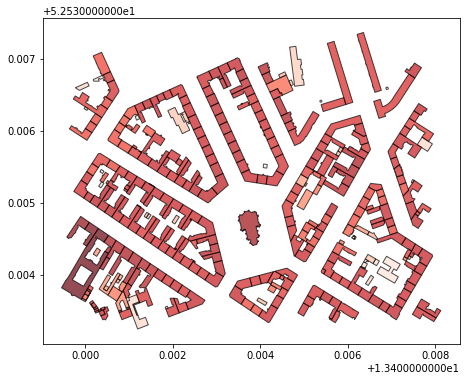

In [374]:
gdfcx = gdf.cx[13.40005 : 13.407602, 52.5335 : 52.53682]
gdfcx = gdfcx.rename({'OBJECTID': 'id', 'Mean_nDOM': 'height'}, axis='columns')
gdfcx.drop([x for x in gdfcx.columns if x not in ['id', 'height', 'geometry']], axis=1, inplace=True)
gdfcx.plot(figsize=(10,6), column='height', cmap='Reds', edgecolor='black', alpha=0.7)

In [26]:
azimuth = 225 # angle clockwise to north

<AxesSubplot:>

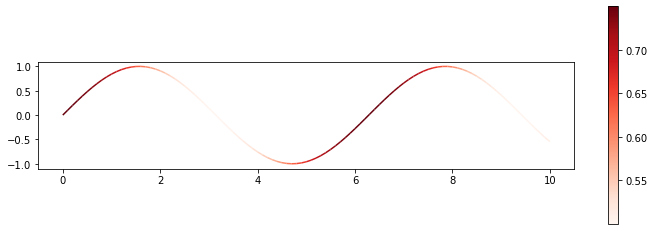

In [37]:
s = GeoDataFrame({'orientation': [(azimuth - angleToNorth((x/10, math.sin(x/10)), ((x+1)/10, math.sin((x+1)/10)))+90)/360 \
    for x in range(100)] }, \
    geometry=[LineString([(x/10, math.sin(x/10)), ((x+1)/10, math.sin((x+1)/10))]) for x in range(100)])
s.plot(figsize=(12,4), cmap="Reds", column='orientation', legend=True)

<AxesSubplot:>

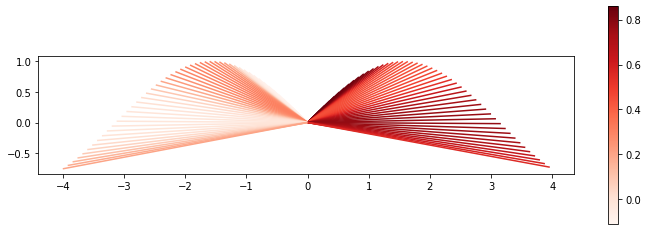

In [118]:
s = GeoDataFrame({'orientation_0': [(azimuth - angleToNorth((0, 0), ((x+1)/100*(-1)**x, math.sin((x+1)/10)))+90)/360 \
    for x in range(100)],
    'orientation_1': [(azimuth - angleToNorth((x/10, math.sin(x/10)), ((x+1)/10, math.sin((x+1)/10)))+90)/360 \
    for x in range(100)]}, \
    geometry=[LineString([(0,0), ((x+1)/25*(-1)**x, math.sin((x+1)/25))]) for x in range(100)])
s.plot(figsize=(12,4), cmap="Reds", column='orientation_0', legend=True)

In [149]:
smpl = gdfcx
meter_factor = toggleMetersToDegrees((0,1))
# cmp = plt.get_cmap('YlOrBr', 100)

a = [item for sublist in [
        [{
            'poly': Polygon([(x,y+meter_factor[1]*h) for x,y in cc]), 
            'height': h,
            'minOffset': min([x*0+y*1 for (x,y) in cc]),
            'role': 'roof'
        } for cc in getConvexCoords(g, triangleMethod=False,plot=False)] + 
        [{
            'poly': Polygon([(x0, y0), (x1, y1), (x1, y1+meter_factor[1]*h), (x0, y0+meter_factor[1]*h)]),
            'height': h,
            'minOffset': min([x0*0+y0*1, x1*0+y1*1]),
            'role': 'wall',
            'orientation': (azimuth - angleToNorth((x0,y0), (x1,y1))+90)/360
        } for (x0, y0), (x1, y1) in zip(g.exterior.coords[:-1], g.exterior.coords[1:])]
        for g, h in zip(np.array(smpl.geometry), np.array(smpl.height))
    ] for item in sublist]
a.sort(key=lambda x: (x['minOffset'], x['role']=='roof'), reverse=True)

poly_gdf = GeoDataFrame({
    'minOffset':[x['minOffset'] for x in a], 
    'height':[x['height'] for x in a], 
    'role':[x['role'] for x in a],
    'clr_0_100':[round(100-100*x['orientation']) if x['role']=='wall' else 10 for x in a], 
    }, geometry=[x['poly'] for x in a], crs=smpl.crs)
edge_gdf = GeoSeries([x['poly'].exterior for x in a if x['role']=='wall'], crs=smpl.crs)
poly_gdf


,minOffset,height,role,clr_0_100,geometry
0,52.537338,19.78,wall,35,"POLYGON ((13.40621 52.53734, 13.40636 52.53737..."
1,52.537275,19.78,wall,105,"POLYGON ((13.40624 52.53728, 13.40621 52.53734..."
2,52.537269,19.78,wall,105,"POLYGON ((13.40625 52.53727, 13.40624 52.53728..."
3,52.537268,19.78,wall,33,"POLYGON ((13.40624 52.53727, 13.40625 52.53727..."
4,52.537242,19.78,roof,10,"POLYGON ((13.40625 52.53745, 13.40624 52.53745..."
...,...,...,...,...,...
6081,52.533243,4.43,roof,10,"POLYGON ((13.40124 52.53341, 13.40108 52.53347..."
6082,52.533243,4.43,roof,10,"POLYGON ((13.40128 52.53342, 13.40124 52.53341..."
6083,52.533243,4.43,roof,10,"POLYGON ((13.40120 52.53328, 13.40134 52.53332..."
6084,52.533243,4.43,wall,84,"POLYGON ((13.40134 52.53328, 13.40120 52.53324..."


(52.53374320939021, 52.536543303486546)

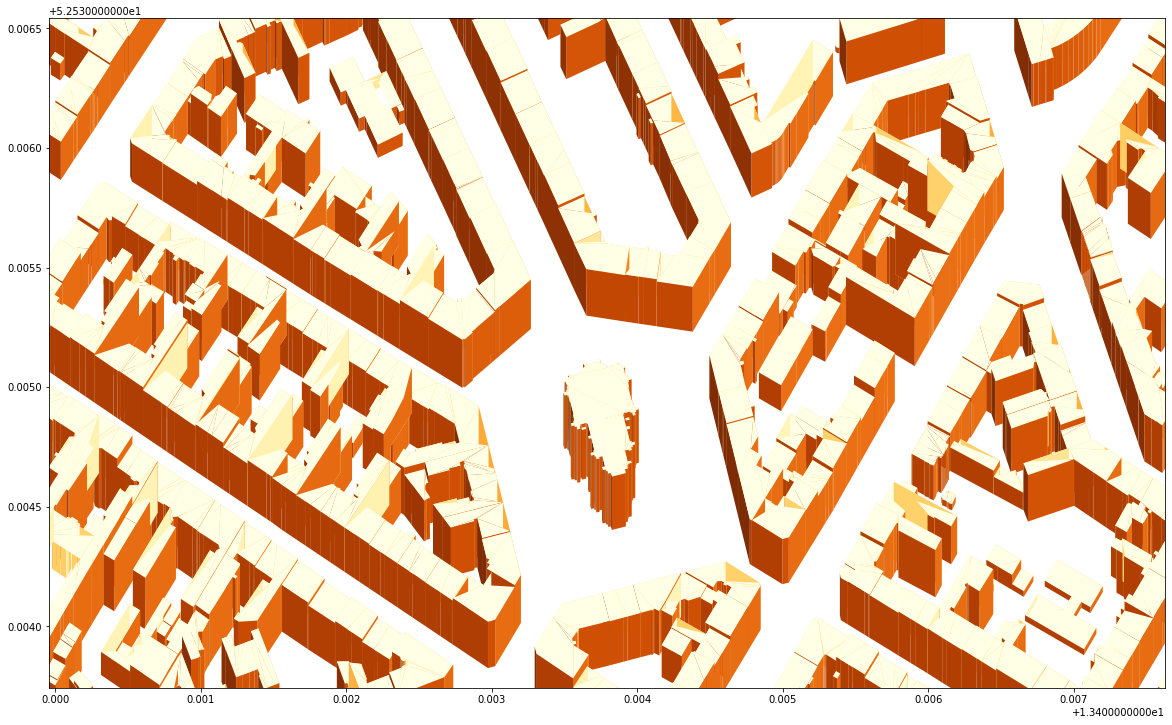

In [150]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,20))

poly_gdf.plot(ax=ax, cmap='YlOrBr', column='clr_0_100', alpha=1.0)
# gdfcx.plot(ax=ax, color='black', alpha=.3)
# poly_gdf[poly_gdf['role']=='roof'].plot(ax=ax, alpha=.5)
# poly_gdf.plot(ax=ax, color='clr_0_100', alpha=0.6)
# edge_gdf.plot(ax=ax, color='black')
b = poly_gdf.total_bounds

ax.set_xlim(b[0]+0.0005, b[2]-0.0005)
ax.set_ylim(b[1]+0.0005, b[3]-0.001)

In [72]:
10**len(str(len(smpl)))

1000

In [97]:
smpl.index[[len(g.interiors)>0 for g in smpl.geometry]]

Int64Index([17733, 25845], dtype='int64')

In [135]:
g= smpl.geometry.loc[17733]
r=[list(g.exterior.coords)] + [list(i.coords[::-1]) for i in g.interiors]

In [136]:
definedClockwise(g.exterior.coords)

True

In [137]:
g.is_valid

True

In [128]:
og_c_arrs = np.array([[list(g.exterior.coords)] + [list(i.coords[::-1]) for i in g.interiors] for g in smpl.geometry])[10]
og_c_arr = og_c_arrs[0]
z = zip()
c0, c1 = og_c_arr[2], og_c_arr[3]


C:\Users\BSE\AppData\Local\Temp\ipykernel_1756\3549419169.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  og_c_arrs = np.array([[list(g.exterior.coords)] + [list(i.coords[::-1]) for i in g.interiors] for g in smpl.geometry])[10]


In [129]:
any([
    c0 in og_c_arr and c1 in og_c_arr and og_c_arr.index(c1)==(og_c_arr.index(c0)+1)%len(og_c_arr) for og_c_arr in og_c_arrs
])

True

In [155]:
def makeCounterClockWise(arr, bl):
    if bl==definedClockwise(arr):
        arr = arr[::-1]
    return arr

In [ ]:
# defined geometries such that all extieriors are counter clockwise and interiors clockwise


In [379]:
smpl = gdfcx
# smpl = gdfcx.cx[13.4045 : 13.4048, 52.53398 : 52.5342]
# smpl = gdfcx.cx[13.4045 : 13.40455, 52.53398 : 52.53399]
smpl = gdfcx.cx[13.4002 : 13.4005, 52.5335 : 52.534]
# smpl = smpl[:1]
smpl['geometry'] = [Polygon(makeCounterClockWise(g.exterior.coords, True), [makeCounterClockWise(i.coords, False) for i in g.interiors]) for g in smpl['geometry']] 
meter_factor_x, meter_factor_y = toggleMetersToDegrees((0,1))
# cmp = plt.get_cmap('YlOrBr', 100)
maxCoordLen = len(\
    str(max([len(g.exterior.coords) + sum([len(i.coords[::-1]) for i in g.interiors]) for g in smpl.geometry]))\
)

a = [item for sublist in [item for sublist in [
        [[[{
            'poly': Polygon([(x,y+meter_factor_y*h) for x,y in cc]), 
            'height': h,
            'minOffset': min([x*0+y*1 for (x,y) in cc]),
            'roofOffset': min([x*0+y*1 for (x,y) in cc]),
            'role': 'roof',
            'g_id': g_id,
            'roof_id': g_id + n*10**maxCoordLen,
            'self_id': g_id + n*10**maxCoordLen,
            'valid': True
        }] + 
        [{
            'poly': Polygon([c0, c1, (c1[0], c1[1]+meter_factor_y*h), (c0[0], c0[1]+meter_factor_y*h)]), 
            'height': h,
            'minOffset': min([c0[0]*0+c0[1]*1, c1[0]*0+c1[1]*1]),
            'roofOffset': min([x*0+y*1 for (x,y) in cc]),
            'role': 'wall',
            'g_id': g_id,
            'roof_id': g_id + n*10**maxCoordLen,
            'self_id': g_id + n*10**maxCoordLen + n_,
            'orientation': (azimuth - angleToNorth(c0, c1)+90)/360,
            'valid': any([
                c0 in og_c_arr and c1 in og_c_arr and og_c_arr.index(c1)==(og_c_arr.index(c0)+1)%(len(og_c_arr)-1) for og_c_arr in og_c_arrs
            ]) and not c0 == c1
            }
            for n_, c0,c1 in zip(range(len(cc)), cc, cc[1:]+[cc[0]])
            ]
                for n, cc in enumerate(ccs)] for ccs in [getConvexCoords(g, triangleMethod=False,plot=False)]][0]
        for g_id, g, h, og_c_arrs in zip(
            (np.array(range(len(smpl)))+10**len(str(len(smpl))))*10**maxCoordLen,
            np.array(smpl.geometry), 
            np.array(smpl.height), 
            np.array([[list(g.exterior.coords)] + [list(i.coords[::-1]) for i in g.interiors] for g in smpl.geometry])
            )
    ] for item in sublist] for item in sublist]

a.sort(key=lambda x: (x['roofOffset'], x['role']=='wall', x['minOffset']), reverse=True)

poly_gdf = GeoDataFrame({
    'geom_type': [item for sublist in [['poly', 'edge'] for x in a] for item in sublist],
    'height': [item for sublist in [[x['height']]*2 for x in a] for item in sublist], 
    'minOffset': [item for sublist in [[x['minOffset']]*2 for x in a] for item in sublist], 
    'role': [item for sublist in [[x['role']]*2 for x in a] for item in sublist],
    'clr_0_100': [item for sublist in [[round(100-100*x['orientation']) if x['role']=='wall' else 10, 80] for x in a] for item in sublist],
    'g_id': [item for sublist in  [[x['g_id']]*2 for x in a] for item in sublist],
    'roof_id': [item for sublist in  [[x['roof_id']]*2 for x in a] for item in sublist],
    'self_id': [item for sublist in  [[x['self_id']]*2 for x in a] for item in sublist],
    'valid': [item for sublist in  [[x['valid'], x['valid'] and x['role']=='wall'] for x in a] for item in sublist] 
    }, 
    geometry=[item for sublist in [[x['poly'], x['poly'].exterior.buffer(1e-6*2)] for x in a] for item in sublist], 
    crs=smpl.crs
)
poly_gdf = poly_gdf[poly_gdf['valid']]
# edge_gdf = poly_gdf[poly_gdf['role']=='wall']
# edge_gdf['geometry'] = [g.exterior for g in edge_gdf['geometry']]
poly_gdf.head(3)


c:\Users\BSE\.conda\envs\geo-env\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\BSE\AppData\Local\Temp\ipykernel_1756\865743845.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([[list(g.exterior.coords)] + [list(i.coords[::-1]) for i in g.interiors] for g in smpl.geometry])


,geom_type,height,minOffset,role,clr_0_100,g_id,roof_id,self_id,valid,geometry
0,poly,27.93,52.534581,wall,94,101000,138000,138001,True,"POLYGON ((13.40045 52.53458, 13.40042 52.53459..."
1,edge,27.93,52.534581,wall,80,101000,138000,138001,True,"POLYGON ((13.40045 52.53458, 13.40045 52.53458..."
6,poly,27.93,52.534523,roof,10,101000,138000,138000,True,"POLYGON ((13.40025 52.53477, 13.40045 52.53483..."


<AxesSubplot:>

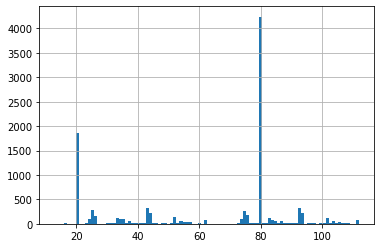

In [364]:
poly_gdf['clr_0_100'].hist(bins=100)

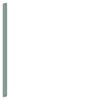

In [341]:
poly_gdf.iloc[0]['geometry'].buffer(0.0000001)

In [376]:
poly_gdf[poly_gdf['role']=='roof']['clr_0_100'].max()

10

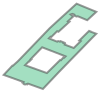

In [383]:
smpl.iloc[1]['geometry']

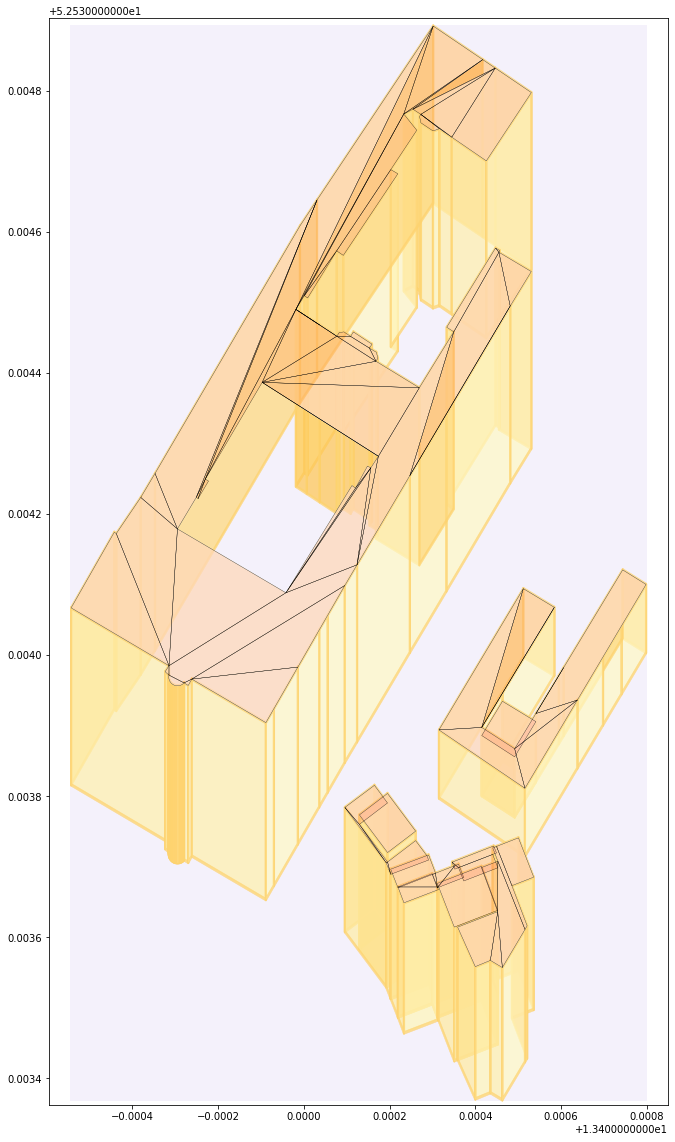

In [380]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,20))
b = poly_gdf.total_bounds
GeoSeries([Polygon([(b[0], b[1]), (b[2], b[1]), (b[2], b[3]), (b[0], b[3])])]).plot(ax=ax, color="#ccbbee", alpha=.2)
# smpl.plot(ax=ax, color='red', alpha=.2)
# smpl.plot(ax=ax, color='None', edgecolor="black", linewidth=2)
# poly_gdf[poly_gdf['role']=='wall'].plot(ax=ax, cmap='YlOrBr', column='clr_0_100', alpha=1)
poly_gdf.plot(ax=ax, 
    color=plt.cm.YlOrBr(poly_gdf['clr_0_100']), 
    edgecolor=plt.cm.YlOrBr(poly_gdf['clr_0_100']), linewidth=.5,
    alpha=.71)
poly_gdf[poly_gdf['role']=='roof'].plot(ax=ax, color='red', edgecolor='None', alpha=.1)
poly_gdf[poly_gdf['role']=='roof'].plot(ax=ax, color='None', edgecolor='black', linewidth=.3)
# poly_gdf[poly_gdf['g_id']==1000].plot(ax=ax, color="blue", edgecolor="black", column='clr_0_100', alpha=.3)
# poly_gdf.plot(ax=ax, alpha=.5)
# edge_gdf.plot(ax=ax, color='black', alpha=.3)
# poly_gdf[poly_gdf['role']=='roof'].plot(ax=ax, alpha=.5)
# poly_gdf.plot(ax=ax, color='clr_0_100', alpha=0.6)
# edge_gdf.plot(ax=ax, color='black')

ax.set_xlim(b[0]+0.0005*-0.1, b[2]-0.0005*-0.1)
ax.set_ylim(b[1]+0.0005*-0.01, b[3]-0.001*-0.01)


plt.savefig('./plots/3D_map_neut_'+str(datetime.now())[0:13]+'.png', dpi=300)

<AxesSubplot:>

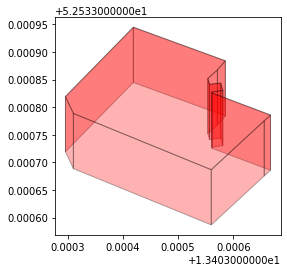

In [ ]:
cc = gdfcx.iloc[0]['geometry'].exterior.coords
ps = [Polygon([(x0, y0), (x1, y1), (x1, y1+0.0001*1), (x0, y0+0.0001*1)]) for (x0, y0), (x1, y1) in zip(cc[:-1], cc[1:])]
GeoSeries(ps+[Polygon([(x,y+0.0001*1) for (x,y) in cc])]).plot(color='red', edgecolor='black', alpha=.3)

In [ ]:
a.iloc[1]

[{'polyCoords': [(13.402944328107997, 52.53397948901929),
   (13.402838580790496, 52.53402230686889),
   (13.402732960971912, 52.533924379606354)],
  'height': 21.55},
 {'polyCoords': [(13.402732960971912, 52.533924379606354),
   (13.402974877752758, 52.53382562571324),
   (13.403024279164427, 52.533833708169624),
   (13.403159170838709, 52.53397153679631),
   (13.402944328107997, 52.53397948901929)],
  'height': 21.55},
 {'polyCoords': [(13.403159170838709, 52.53397153679631),
   (13.40299800822812, 52.53403007595436),
   (13.402944328107997, 52.53397948901929)],
  'height': 21.55}]

In [25]:
def prep_gdf_prisms_neutral_perspective(gdf_h:GeoDataFrame, opacity:float=1.0, colorScheme:str=None, angle:float=180.0, heightFactor=1.0, origin=(.5, 1.0, 'relative')) -> GeoDataFrame:
    if not angle == 180:
        print('turn gdf...')
    if not all([x.exterior.coords[0]==x.exterior.coords[-1] for x in gdf_h.geometry]):
        print('Assumption that first and last coordinate of sequence are the same is not met. This implies that walls will be missing.')
    
    gdf_h
    
    return

c:\Users\BSE\.conda\envs\geo-env\lib\site-packages\geopandas\plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


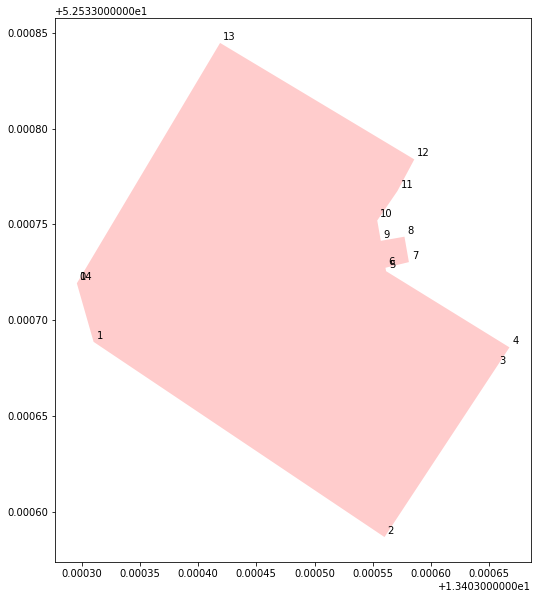

In [319]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10))
poly_gdf[poly_gdf['g_id']==1000].plot(ax=ax, color="blue", alpha=.2)
edge_gdf[edge_gdf['g_id']==1000].plot(ax=ax,color="black")
smpl[:1].plot(ax=ax, color='red', alpha=.2)
extCoords = smpl[:1]['geometry'].iloc[0].exterior.coords
for x, y, label in zip([extCoords[x][0] for x in range(len(extCoords))], [extCoords[x][1] for x in range(len(extCoords))], [str(x) for x in range(len(extCoords))]):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

In [ ]:
def plot_prisms_neutral_perspective(polygonsWithHeight:GeoDataFrame, opacity:float=1.0, colorScheme:str=None, angle:float=180.0) -> None:
    if not angle == 180:
        print('turn gdf...')
    
    return

In [ ]:
a.iloc[1]

[([(13.402944328107997, 52.53397948901929),
   (13.402838580790496, 52.53402230686889),
   (13.402732960971912, 52.533924379606354)],
  21.55),
 ([(13.402732960971912, 52.533924379606354),
   (13.402974877752758, 52.53382562571324),
   (13.403024279164427, 52.533833708169624),
   (13.403159170838709, 52.53397153679631),
   (13.402944328107997, 52.53397948901929)],
  21.55),
 ([(13.403159170838709, 52.53397153679631),
   (13.40299800822812, 52.53403007595436),
   (13.402944328107997, 52.53397948901929)],
  21.55)]